## Sitting Posture Detection Training

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

### Define Dataset class

In [171]:
class PostureDataset(Dataset):
    def __init__(self, data, scaler=None, label_encoder=None, from_csv=True):
        """
        Args:
        - data: CSV file path or DataFrame containing the dataset.
        - scaler: StandardScaler for feature normalization.
        - label_encoder: LabelEncoder for encoding the labels (not required if already encoded).
        - from_csv: Set to True if the input is a CSV path.
        """

        self.label_encoder = label_encoder

        # Load data
        if from_csv:
            data = pd.read_csv(data)
        
        # Ensure required columns are present
        if 'class' not in data.columns:
            raise ValueError("The input data must contain a 'class' column.")
        
        # Extract features and labels
        self.X = data.drop(columns=['class']).values  # Features
        self.y = data['class'].values  # Labels (already encoded)

        # Normalize features using StandardScaler
        if scaler:
            self.X = scaler.transform(self.X)
        else:
            self.scaler = StandardScaler()
            self.X = self.scaler.fit_transform(self.X)
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)  # Ensure labels are integers

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_class_label(self):
        """Print class encoding, actual labels"""
        class_labels = self.label_encoder.classes_

        print("\nClass Index to Label Mapping:")
        for idx, label in enumerate(class_labels):
            print(f"  {idx}: {label}")      

    def get_class_info(self):
        """Print number of samples per class."""
        class_labels = self.label_encoder.classes_
        
        print("\nNumber of Samples per Class:")
        class_counts = pd.Series(self.y.numpy()).value_counts()
        for idx, count in class_counts.items():
            print(f"  {idx} ({class_labels[idx]}): {count} samples")

### Define ANN Model Architecture

In [183]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),  # Increase neurons
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

### Define Utility Functions

1. Train test loss & accuracy plot
2. Confusion matrix
3. Classification report
4. Export model

In [184]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch
import os

def plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies, save_dir=None):
    """
    Plots training and validation loss and accuracy side by side.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Validation Loss")
    axes[0].set_title("Loss Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Plot Accuracy
    axes[1].plot(train_accuracies, label="Train Accuracy")
    axes[1].plot(val_accuracies, label="Validation Accuracy")
    axes[1].set_title("Accuracy Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, "train_test_plot.png"))
    plt.show()


def plot_confusion_matrix(model, data_loader, class_labels, device, save_dir=None):
    """
    Generates and plots the confusion matrix with per-class accuracy and prints a classification report.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_labels)))
    
    # Calculate per-class accuracy
    class_accuracy = {}
    for i, label in enumerate(class_labels):
        true_positives = cm[i, i]
        total_samples = cm[i].sum()
        accuracy = (true_positives / total_samples) * 100 if total_samples > 0 else 0
        class_accuracy[label] = accuracy

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.show()
    plt.show()
    
    # Print per-class accuracy
    print("\nPer-Class Accuracy:")
    for label, acc in class_accuracy.items():
        print(f"  {label}: {acc:.2f}%")
        
    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=class_labels)
    print("\nClassification Report:\n", report)

    if save_dir:
        with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
            f.write(report)

    return class_accuracy

def save_model_with_config(scaler, model, model_name, save_dir):
    """
    Save the PyTorch model state dictionary to a specified directory.
    Save scaler_mean and scaler_scale to the same directory.
    """
    # Save the model state dictionary
    model_path = os.path.join(save_dir, model_name)
    torch.save(model.state_dict(), model_path)

    # Save the scaler's mean and scale as NumPy arrays
    np.save(os.path.join(save_dir, "scaler_mean.npy"), scaler.mean_)
    np.save(os.path.join(save_dir, "scaler_scale.npy"), scaler.scale_)

    print(f"Model saved to: {model_path}")
    print(f"Scaler mean saved to: {os.path.join(save_dir, 'scaler_mean.npy')}")
    print(f"Scaler scale saved to: {os.path.join(save_dir, 'scaler_scale.npy')}")


### Define the Training & Evaluation Function

In [185]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Initialize lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Print epoch stats
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Val Acc: {val_accuracies[-1]:.4f}")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

### Load Preprocessed Dataset

In [186]:
# Load and preprocess data
csv_path = "../../datasets/vectors/augmented_xy_filtered_keypoints_vectors_mediapipe.csv"
df = pd.read_csv(csv_path)  

print("Number of samples per class before train test split:")
print(df['class'].value_counts())

Number of samples per class before train test split:
class
crossed_legs    411
proper          400
slouching       369
reclining       365
Name: count, dtype: int64


### Encode Class Labels

In [187]:
# Encode class labels to integers using LabelEncoder
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

### Train Test Split

In [188]:

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32

# Split the data into training and test datasets
train_data, test_data = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)

### Feature Normalisation using StandardScaler

In [189]:
# Standardize features
scaler = StandardScaler()
train_features = train_data.drop(columns=['class']).values
scaler.fit(train_features)

StandardScaler()

### Apply SMOTE to address class imbalanced

In [190]:
""" APPLY SMOTE
train_labels = train_data['class'].values
print("\n------------------------------------")
print(f"Training samples before SMOTE: {len(train_data)}")
print(f"Class distribution before SMOTE: {Counter(train_labels)}")

smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(train_features, train_labels)

print("\n------------------------------------")
print(f"Training samples after SMOTE: {len(X_resampled)}")
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Convert resampled data back to a DataFrame
train_data = pd.DataFrame(X_resampled, columns=train_data.columns[:-1])  # Feature columns
train_data["class"] = y_resampled  # Add the resampled class labels
"""

' APPLY SMOTE\ntrain_labels = train_data[\'class\'].values\nprint("\n------------------------------------")\nprint(f"Training samples before SMOTE: {len(train_data)}")\nprint(f"Class distribution before SMOTE: {Counter(train_labels)}")\n\nsmote = SMOTE(random_state=RANDOM_SEED)\nX_resampled, y_resampled = smote.fit_resample(train_features, train_labels)\n\nprint("\n------------------------------------")\nprint(f"Training samples after SMOTE: {len(X_resampled)}")\nprint(f"Class distribution after SMOTE: {Counter(y_resampled)}")\n\n# Convert resampled data back to a DataFrame\ntrain_data = pd.DataFrame(X_resampled, columns=train_data.columns[:-1])  # Feature columns\ntrain_data["class"] = y_resampled  # Add the resampled class labels\n'

### Create DataLoaders

In [191]:
# Create datasets and loaders
train_dataset = PostureDataset(train_data, scaler=scaler, label_encoder=label_encoder, from_csv=False)
print("Class Label Mapping: ")
train_dataset.get_class_label()
print("\n------------------------------------")
print("Training dataset:")
train_dataset.get_class_info()
print("\n------------------------------------")
test_dataset = PostureDataset(test_data, scaler=scaler, label_encoder=label_encoder, from_csv=False)
print("Testing dataset:")
test_dataset.get_class_info()
print("\n------------------------------------")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Class Label Mapping: 

Class Index to Label Mapping:
  0: crossed_legs
  1: proper
  2: reclining
  3: slouching

------------------------------------
Training dataset:

Number of Samples per Class:
  0 (crossed_legs): 296 samples
  1 (proper): 278 samples
  2 (reclining): 257 samples
  3 (slouching): 250 samples

------------------------------------
Testing dataset:

Number of Samples per Class:
  1 (proper): 122 samples
  3 (slouching): 119 samples
  0 (crossed_legs): 115 samples
  2 (reclining): 108 samples

------------------------------------


### Initialise Model

In [192]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.001
NUM_CLASSES = 4
EPOCHS = 400

# Model initialization
input_size = train_features.shape[1]
model = MLP(input_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### Train Model and Plot Results

Epoch [1/400], Train Loss: 1.1422, Train Acc: 0.4847, Val Loss: 0.9276, Val Acc: 0.6142
Epoch [2/400], Train Loss: 0.9293, Train Acc: 0.6115, Val Loss: 0.7360, Val Acc: 0.7047
Epoch [3/400], Train Loss: 0.7846, Train Acc: 0.6855, Val Loss: 0.6551, Val Acc: 0.7284
Epoch [4/400], Train Loss: 0.6999, Train Acc: 0.7197, Val Loss: 0.5954, Val Acc: 0.7565
Epoch [5/400], Train Loss: 0.6683, Train Acc: 0.7419, Val Loss: 0.5769, Val Acc: 0.7823
Epoch [6/400], Train Loss: 0.6649, Train Acc: 0.7327, Val Loss: 0.5447, Val Acc: 0.7737
Epoch [7/400], Train Loss: 0.6578, Train Acc: 0.7428, Val Loss: 0.5356, Val Acc: 0.7909
Epoch [8/400], Train Loss: 0.6155, Train Acc: 0.7502, Val Loss: 0.5354, Val Acc: 0.7909
Epoch [9/400], Train Loss: 0.6420, Train Acc: 0.7382, Val Loss: 0.5107, Val Acc: 0.8168
Epoch [10/400], Train Loss: 0.5630, Train Acc: 0.7641, Val Loss: 0.4872, Val Acc: 0.8190
Epoch [11/400], Train Loss: 0.5573, Train Acc: 0.7780, Val Loss: 0.4413, Val Acc: 0.8384
Epoch [12/400], Train Loss: 0.

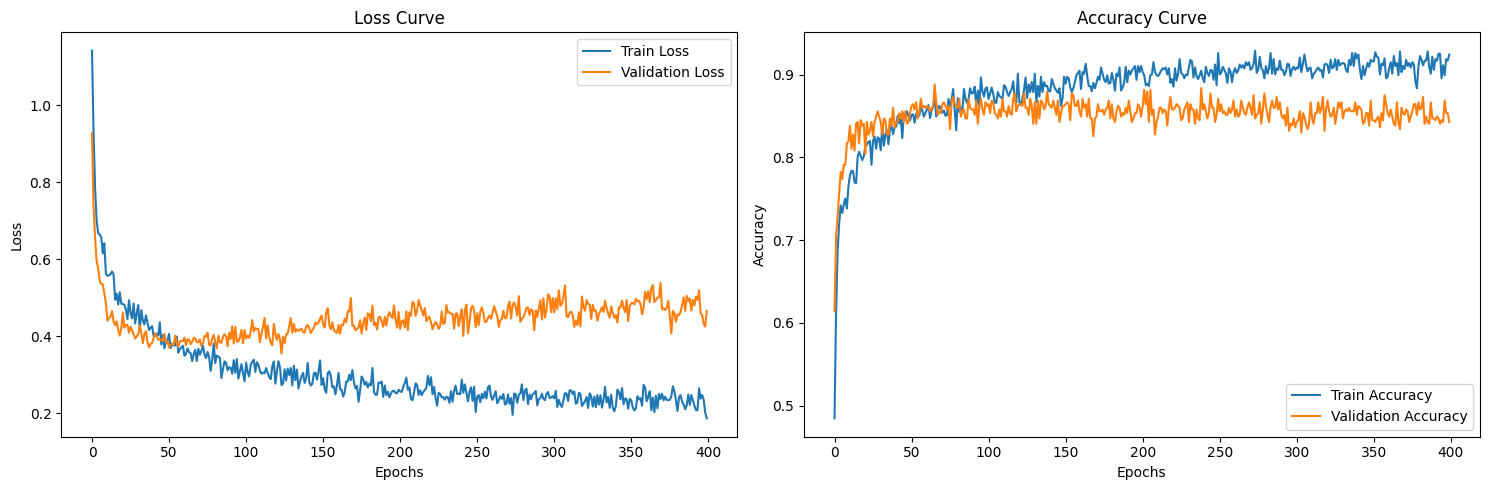

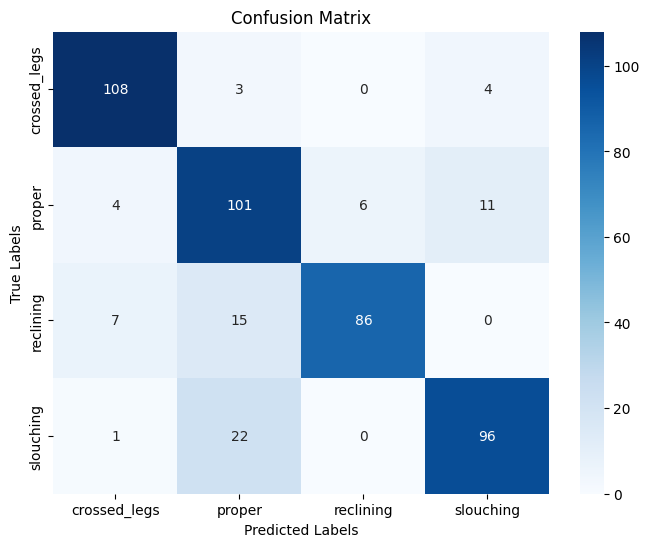


Per-Class Accuracy:
  crossed_legs: 93.91%
  proper: 82.79%
  reclining: 79.63%
  slouching: 80.67%

Classification Report:
               precision    recall  f1-score   support

crossed_legs       0.90      0.94      0.92       115
      proper       0.72      0.83      0.77       122
   reclining       0.93      0.80      0.86       108
   slouching       0.86      0.81      0.83       119

    accuracy                           0.84       464
   macro avg       0.85      0.84      0.85       464
weighted avg       0.85      0.84      0.84       464



In [182]:
import datetime

SAVE_RESULT = False
MODEL_NAME = "epochs_300_lr_1e-03_wd_1e-02_acc_9581.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_labels = label_encoder.classes_
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS)

save_dir = None
if SAVE_RESULT:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join("../models", timestamp)
    os.makedirs(save_dir, exist_ok=True)

plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies, save_dir=save_dir)
plot_confusion_matrix(model, test_loader, class_labels, device, save_dir=save_dir)

if SAVE_RESULT:
    save_model_with_config(scaler, model, MODEL_NAME, save_dir)